
# 提前停止隨機梯度下降


隨機梯度下降是一種優化技術，它以隨機方式使損失函數最小化，逐個樣本執行梯度下降步驟，這是擬合線性模型的非常有效的方法。

作為一種隨機方法，損失函數不必在每次迭代時都減小，並且只能在期望中保證收斂，因此可能難以監視損失函數的收斂性。

另一種方法是監視驗證分數上的收斂。在這種情況下，將輸入資料分為訓練集和驗證集。然後將模型擬合到訓練集上，停止標準基於在驗證集上計算出的預測得分。這使我們能夠找到最少的迭代次數，足以構建一個模型，該模型可以很好地泛化未見數據，並減少過度擬合訓練資料的機會。

如果ʻearly_stopping = True``，則啟動該提前停止策略；否則，停止標準僅對整個輸入數據使用訓練損失。為了更好地控制早期停止策略，我們可以指定參數``validation_fraction''來設置輸入數據集的分數，我們將其保留以計算驗證分數。優化將繼續直到在最後一次n_iter_no_change迭代期間驗證得分沒有提高至少tol為止。實際的迭代次數可在屬性``n_iter_''處獲得。

此操作實例說明如何在：class：`sklearn.linear_model.SGDClassifier`模型中使用提前停止，與未提前停止構建的模型相比，可以達到幾乎相同的精度。這樣可以大大減少培訓時間。請注意，得分之間甚至從早期迭代就達到停止標準，因為一些訓練數據與驗證停止標準一起保留。

In [1]:
#導入需要套件
%matplotlib inline
import time
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
def load_mnist(n_samples=None, class_0='0', class_1='8'):
    """載入MNIST, 隨機選擇兩個類別，並僅返回n_samples個"""
    # Load data from http://openml.org/d/554
    mnist = fetch_openml('mnist_784', version=1)

    # 僅採用兩個類別進行二分類
    mask = np.logical_or(mnist.target == class_0, mnist.target == class_1)

    X, y = shuffle(mnist.data[mask], mnist.target[mask], random_state=42)
    if n_samples is not None:
        X, y = X[:n_samples], y[:n_samples]
    return X, y

In [3]:
@ignore_warnings(category=ConvergenceWarning)
def fit_and_score(estimator, max_iter, X_train, X_test, y_train, y_test):
    """將估算器擬合到訓練資料集上，並在兩個集合上對其進行評分"""
    estimator.set_params(max_iter=max_iter)
    estimator.set_params(random_state=0)

    start = time.time()
    estimator.fit(X_train, y_train)

    fit_time = time.time() - start
    n_iter = estimator.n_iter_
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return fit_time, n_iter, train_score, test_score

In [4]:
# 定義用於比較的模型
estimator_dict = {
    'No stopping criterion':
    linear_model.SGDClassifier(n_iter_no_change=3),
    'Training loss':
    linear_model.SGDClassifier(early_stopping=False, n_iter_no_change=3,
                               tol=0.1),
    'Validation score':
    linear_model.SGDClassifier(early_stopping=True, n_iter_no_change=3,
                               tol=0.0001, validation_fraction=0.2)
}

No stopping criterion: .................................................
Training loss: .................................................
Validation score: .................................................


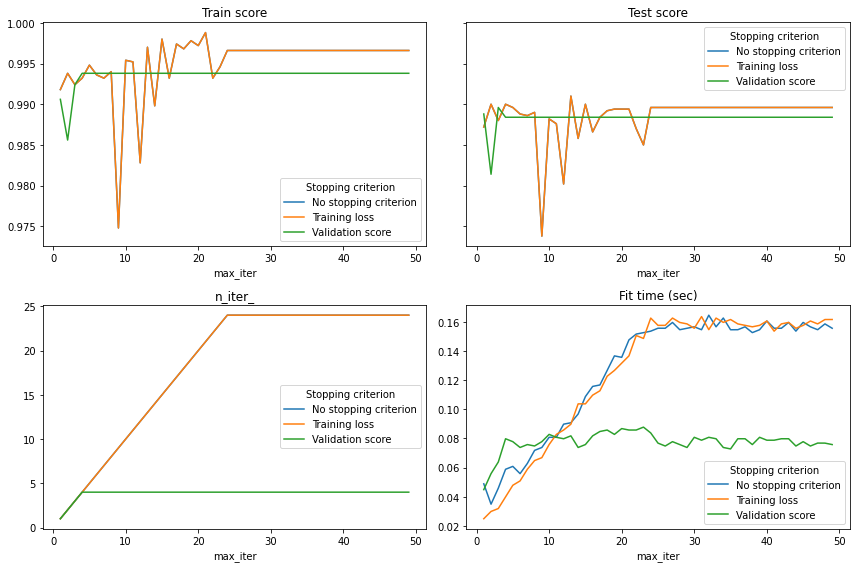

In [5]:
# 正式載入資料集
X, y = load_mnist(n_samples=10000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=0)

results = []
for estimator_name, estimator in estimator_dict.items():
    print(estimator_name + ': ', end='')
    for max_iter in range(1, 50):
        print('.', end='')
        sys.stdout.flush()

        fit_time, n_iter, train_score, test_score = fit_and_score(
            estimator, max_iter, X_train, X_test, y_train, y_test)

        results.append((estimator_name, max_iter, fit_time, n_iter,
                        train_score, test_score))
    print('')

# 轉換結果成pandas dataframe以便畫圖
columns = [
    'Stopping criterion', 'max_iter', 'Fit time (sec)', 'n_iter_',
    'Train score', 'Test score'
]
results_df = pd.DataFrame(results, columns=columns)

# 定義要畫的 (x_axis, y_axis)
lines = 'Stopping criterion'
plot_list = [
    ('max_iter', 'Train score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'n_iter_'),
    ('max_iter', 'Fit time (sec)'),
]

nrows = 2
ncols = int(np.ceil(len(plot_list) / 2.))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols,
                                                            4 * nrows))
axes[0, 0].get_shared_y_axes().join(axes[0, 0], axes[0, 1])

for ax, (x_axis, y_axis) in zip(axes.ravel(), plot_list):
    for criterion, group_df in results_df.groupby(lines):
        group_df.plot(x=x_axis, y=y_axis, label=criterion, ax=ax)
    ax.set_title(y_axis)
    ax.legend(title=lines)

fig.tight_layout()
plt.show()

No stopping criterion: .................................................
Training loss: .................................................
Validation score: .................................................


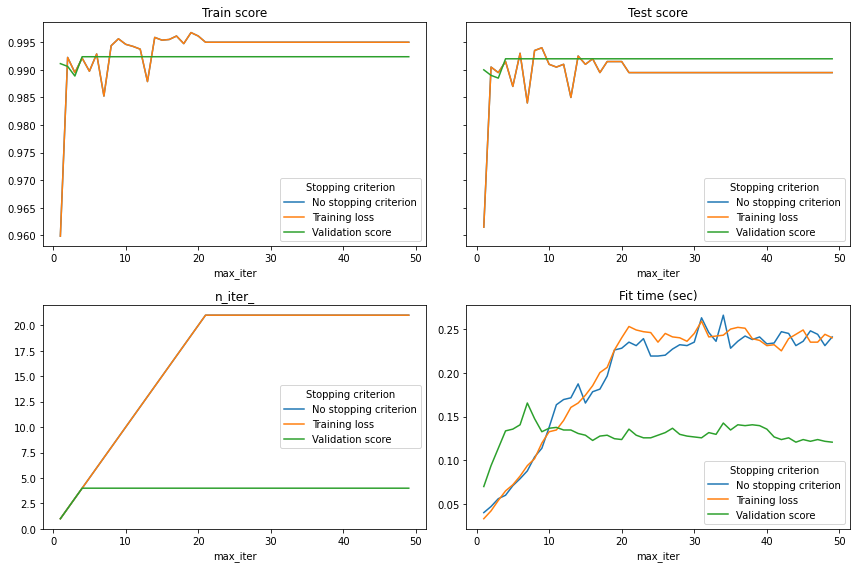

In [6]:
# 載入資料集分割訓練/測試資料集

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

results = []
for estimator_name, estimator in estimator_dict.items():
    print(estimator_name + ': ', end='')
    for max_iter in range(1, 50):
        print('.', end='')
        sys.stdout.flush()

        fit_time, n_iter, train_score, test_score = fit_and_score(
            estimator, max_iter, X_train, X_test, y_train, y_test)

        results.append((estimator_name, max_iter, fit_time, n_iter,
                        train_score, test_score))
    print('')

# 轉換結果成pandas dataframe以便畫圖
columns = [
    'Stopping criterion', 'max_iter', 'Fit time (sec)', 'n_iter_',
    'Train score', 'Test score'
]
results_df = pd.DataFrame(results, columns=columns)

# 定義要畫的 (x_axis, y_axis)
lines = 'Stopping criterion'
plot_list = [
    ('max_iter', 'Train score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'n_iter_'),
    ('max_iter', 'Fit time (sec)'),
]

nrows = 2
ncols = int(np.ceil(len(plot_list) / 2.))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols,
                                                            4 * nrows))
axes[0, 0].get_shared_y_axes().join(axes[0, 0], axes[0, 1])

for ax, (x_axis, y_axis) in zip(axes.ravel(), plot_list):
    for criterion, group_df in results_df.groupby(lines):
        group_df.plot(x=x_axis, y=y_axis, label=criterion, ax=ax)
    ax.set_title(y_axis)
    ax.legend(title=lines)

fig.tight_layout()
plt.show()